# utils

In [1]:
import io 
import os
import unicodedata
import string
import glob

import random
import torch

In [2]:
# alphabet small + capital letters + " .,;'"
ALL_LETTERS = string.ascii_letters + " .,;"
N_LETTERS =  len(ALL_LETTERS)

In [3]:
type(ALL_LETTERS)

str

In [4]:
ALL_LETTERS[7]

'h'

In [5]:
#turn unicpde sdtring into plain ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) !='Mn' and c in ALL_LETTERS)

In [6]:
z = io.open('French.txt', encoding='utf-8')
print(z)

<_io.TextIOWrapper name='French.txt' mode='r' encoding='utf-8'>


In [7]:
a = io.open('French.txt', encoding='utf-8').read()
print(a[0:50])

Abel
Abraham
Adam
Albert
Allard
Archambault
Armist


In [8]:
len(a)

2162

In [9]:
type(a)

str

In [10]:
b = a.strip()
print(b[0:50])

Abel
Abraham
Adam
Albert
Allard
Archambault
Armist


In [11]:
type(b)

str

In [12]:
c = b.split('\n')
c[0:5]

['Abel', 'Abraham', 'Adam', 'Albert', 'Allard']

In [13]:
type(c)

list

In [14]:
len(c)

277

In [22]:
def load_data():
    category_lines = {}
    all_categories = []
    
    def find_files(path):
        return glob.glob(path,recursive=True)
    
    #read file and split into liens
    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]
    
    for filename in find_files("M:/DL/TEXT/from scratch/surname _rnn_data/names/*.txt"):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        
        lines = read_lines(filename)
        category_lines[category] = lines
        
    return category_lines, all_categories


In [23]:
x , y = load_data()
print(y)

['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


In [24]:
print(x['French'])

['Abel', 'Abraham', 'Adam', 'Albert', 'Allard', 'Archambault', 'Armistead', 'Arthur', 'Augustin', 'Babineaux', 'Baudin', 'Beauchene', 'Beaulieu', 'Beaumont', 'Belanger', 'Bellamy', 'Bellerose', 'Belrose', 'Berger', 'Beringer', 'Bernard', 'Bertrand', 'Bisset', 'Bissette', 'Blaise', 'Blanc', 'Blanchet', 'Blanchett', 'Bonfils', 'Bonheur', 'Bonhomme', 'Bonnaire', 'Bonnay', 'Bonner', 'Bonnet', 'Borde', 'Bordelon', 'Bouchard', 'Boucher', 'Brisbois', 'Brodeur', 'Bureau', 'Caron', 'Cavey', 'Chaput', 'Charbonneau', 'Charpentier', 'Charron', 'Chastain', 'Chevalier', 'Chevrolet', 'Cloutier', 'Colbert', 'Comtois', 'Cornett', 'Cote', 'Coupe', 'Courtemanche', 'Cousineau', 'Couture', 'Daniau', 'Daramitz', 'Daviau', 'David', 'Deforest', 'Degarmo', 'Delacroix', 'De la fontaine', 'Deniau', 'Deniaud', 'Deniel', 'Denis', 'De sauveterre', 'Deschamps', 'Descoteaux', 'Desjardins', 'Desrochers', 'Desrosiers', 'Dubois', 'Duchamps', 'Dufort', 'Dufour', 'Duguay', 'Dupond', 'Dupont', 'Durand', 'Durant', 'Duval', 

## now convert to tensors

In [25]:
def letter_index(letter):
    return ALL_LETTERS.find(letter)

print(letter_index('x'))

for i in ALL_LETTERS[0:7]:
    print(i,letter_index(i))

23
a 0
b 1
c 2
d 3
e 4
f 5
g 6


In [26]:
# Just for demonstration, turn a letter into a (1 x n_letters) Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_index(letter)]=1
    return tensor

itensor =  letter_to_tensor('i')
print(type(itensor))
print(itensor.shape)
print(itensor)

<class 'torch.Tensor'>
torch.Size([1, 56])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])


In [27]:
# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors

def line_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_index(letter)]=1
    return tensor

wordtensor = line_tensor('succint')
print(wordtensor.shape)
print(wordtensor)
    


torch.Size([7, 1, 56])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.

In [28]:
category_lines, all_categories = load_data()
print(all_categories.index('French'))


5


In [29]:
def random_train_example(category_lines, all_categories):
    def random_choice(a):
        random_idx = random.randint(0, len(a)-1)
        return a[random_idx]
    
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype = torch.long)
    linetensor = line_tensor(line)
    return category, line, category_tensor, linetensor


In [30]:
category_lines, all_categories = load_data()
p,q,r,s = random_train_example(category_lines, all_categories)

print(p,q,r.shape,s.shape,type(r), type(s),r.dtype, s.dtype)

Korean Hong torch.Size([1]) torch.Size([4, 1, 56]) <class 'torch.Tensor'> <class 'torch.Tensor'> torch.int64 torch.float32


# model

In [31]:
ed = torch.tensor([[2]])
fg = torch.tensor([[3]])
ss = torch.cat((ed,fg),0) #default dimension
ds = torch.cat((ed,fg), 1)
print(ed.shape)
print(ds, ss)
print(ds.shape, ss.shape)

torch.Size([1, 1])
tensor([[2, 3]]) tensor([[2],
        [3]])
torch.Size([1, 2]) torch.Size([2, 1])


In [32]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# from utils import ALL_LETTERS, N_LETTERS
# from utils import letter_index, letter_to_tensor, line_tensor, random_train_example

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)
        
    def forward(self, input_tensor, hidden_tensor):
            
        combined = torch.cat((input_tensor, hidden_tensor), 1)

        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden, combined
        
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)
        
    

In [33]:
N_LETTERS
category_lines, all_categories = load_data()
n_categories = len(all_categories)
n_hidden = 128
rnn = RNN(N_LETTERS,n_hidden,n_categories)

In [34]:
rnn.i2h

Linear(in_features=184, out_features=128, bias=True)

## for letter 

In [35]:
input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()

output, next_hidden, combined = rnn(input_tensor, hidden_tensor)

In [36]:
print(input_tensor.shape)
print(hidden_tensor.shape)
print(combined.shape)

print(output.shape)
print(next_hidden.shape)


torch.Size([1, 56])
torch.Size([1, 128])
torch.Size([1, 184])
torch.Size([1, 18])
torch.Size([1, 128])


## for word

In [37]:
input_tensor = line_tensor('Albert')
hidden_tensor = rnn.init_hidden()

output, next_hidden, combined = rnn(input_tensor[0], hidden_tensor)

In [38]:
print(input_tensor.shape)
print(hidden_tensor.shape)
print(combined.shape)

print(output.shape)
print(next_hidden.shape)


torch.Size([6, 1, 56])
torch.Size([1, 128])
torch.Size([1, 184])
torch.Size([1, 18])
torch.Size([1, 128])


In [39]:
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

print(category_from_output(output))

Vietnamese


In [40]:
criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr = learning_rate)

In [55]:
linetensor.size()

torch.Size([3, 1, 56])

In [56]:
linetensor.size()[0]

3

In [57]:
linetensor.shape

torch.Size([3, 1, 56])

In [58]:
linetensor.shape[0]

3

In [59]:
linetensor[0]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])

In [60]:
def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(linetensor.shape[0]):
        output, hidden, combined = rnn(line_tensor[i],hidden)
        
    loss = criterion(output, category_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output,  loss.item()



4999 4.999 1.6635An/Koreanwrong (Vietnamese)
9999 9.998999999999999 2.2836Filipek/Czechwrong (Polish)
14999 14.999 1.3271Cha/Vietnamesewrong (Korean)
19999 19.999 2.4567Nijo/Chinesewrong (Japanese)
24999 24.999 1.5146Cabral/Arabicwrong (Portuguese)
29999 29.999 1.4203Westerberg/Dutchwrong (German)
34999 34.999 0.8956Chong/Chinesewrong (Korean)
39999 39.999 1.2218Awduloff/Russiancorrect
44999 44.999 7.6112Kokkali/Japanesewrong (Greek)
49999 49.999 3.2621Denis/Greekwrong (French)
54999 54.998999999999995 0.3216Ryoo/Koreancorrect
59999 59.999 2.8124Huroshvili/Italianwrong (Russian)
64999 64.999 0.5746Jeon/Koreancorrect
69999 69.999 1.5421Magalhaes/Portuguesecorrect
74999 74.99900000000001 1.8621Chu/Vietnamesewrong (Korean)
79999 79.999 2.3656OShea/Koreanwrong (Irish)
84999 84.999 2.6160Heintze/Frenchwrong (German)
89999 89.999 0.0072Brisimitzakis/Greekcorrect
94999 94.999 0.1993Sumitimo/Japanesecorrect
99999 99.99900000000001 0.2641Bahar/Arabiccorrect


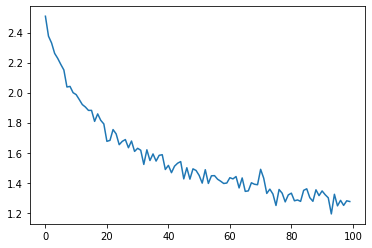

Wall time: 9min 11s


In [64]:
%%time
current_loss = 0
all_losses= []
plot_steps, print_steps = 1000,5000
n_iters =  100000
 
for i in range(n_iters):
    category, line, category_tensor, linetensor = random_train_example(category_lines, all_categories)
    
    output, loss =  train(linetensor, category_tensor)
    current_loss +=loss
    
    if (i+1) % plot_steps ==0:
        all_losses.append(current_loss/plot_steps)
        current_loss = 0
        
    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = 'correct' if guess ==  category else f'wrong ({category})'
        print(f'{i} {i/n_iters*100} {loss:.4f}{line}/{guess}{correct}')
        
plt.figure()
plt.plot(all_losses)
plt.show()
